In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === CONFIG ===
ordination_file = "ordination.json"
contextual_file = "contextual.json"


# === PARAMETERS ===
dissimilarity_method = "braycurtis" # Only "braycurtis" supported at the moment
contextual_variable = "vegetation_type_id"


# === LOAD DATA ===
with open(ordination_file) as f:
    ordination_file_data = json.load(f)

with open(contextual_file) as f:
    contextual_file_data = json.load(f)

contextual = pd.DataFrame(contextual_file_data["samples"]).T
contextual.index.name = "sample_id"
contextual.reset_index(inplace=True)

definitions = {d["name"]: d for d in contextual_file_data["definitions"]}


# === PREP ORDINATIONS AND MERGE CONTEXTUAL DATA ===
ordination = pd.DataFrame(ordination_file_data["points"][dissimilarity_method], columns=["UMAP1", "UMAP2"])
ordination["sample_id"] = ordination_file_data["sample_ids"]
merged = pd.merge(ordination, contextual, on="sample_id", how="left")

In [2]:
# === DETERMINE VARIABLE TYPE & MAP IF ONTOLOGY ===
if contextual_variable not in merged.columns:
    raise ValueError(f"Variable '{contextual_variable}' not found in contextual data.")

definition = definitions.get(contextual_variable)
colour_data = merged[contextual_variable]

# TODO:
# need to handle other types, like date and string (free text)

if definition and definition["type"] == "ontology":
    # Map ontology values, replace empty strings with 'N/A' and create a label column
    value_map = {int(k): (v if v != '' else 'N/A') for k, v in definition["values"]}
    merged[contextual_variable + "_label"] = merged[contextual_variable].map(value_map)
    merged[contextual_variable + "_label"] = merged[contextual_variable + "_label"].fillna("N/A")

    # Preserve sort order by integer key
    categories = [v for _, v in sorted(value_map.items(), key=lambda x: x[0])]

    merged[contextual_variable + "_label"] = pd.Categorical(
        merged[contextual_variable + "_label"], categories=categories, ordered=True
    )

    colour_label = contextual_variable + "_label"
    is_continuous = False
else:
    colour_label = contextual_variable
    is_continuous = True #np.issubdtype(colour_data.dropna().dtype, np.number)


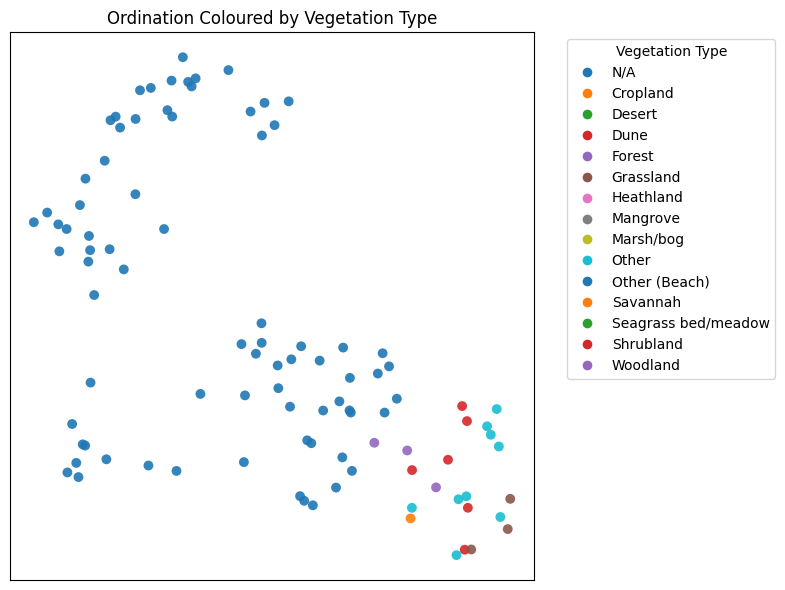


Definition for 'vegetation_type_id':
A description of the dominant type of vegetation



In [3]:
# === PLOT ===
plt.figure(figsize=(8, 6))
ax = plt.gca()

if is_continuous:
    sc = plt.scatter(
        merged["UMAP1"], merged["UMAP2"],
        c=merged[colour_label], cmap="viridis", s=50, edgecolor="none", alpha=0.9
    )
    plt.colorbar(sc, label=definition["display_name"] if definition else contextual_variable)
else:
    palette = sns.color_palette("tab10", len(merged[colour_label].cat.categories))
    colour_map = dict(zip(merged[colour_label].cat.categories, palette))
    colours = np.array([colour_map[val] for val in merged[colour_label]])
    plt.scatter(
        merged["UMAP1"], merged["UMAP2"],
        c=colours, s=50, edgecolor="none", alpha=0.9
    )
    plt.legend(
        handles=[
            plt.Line2D([0], [0], marker='o', color='w', label=str(cat),
                       markerfacecolor=colour_map[cat], markersize=8)
            for cat in categories if pd.notna(cat)
        ],
        title=definition["display_name"] if definition else contextual_variable,
        bbox_to_anchor=(1.05, 1), loc='upper left'
    )
    
# Since this is an ordination the axes and ticks are arbitrary, so remove them
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

title = f"Ordination Coloured by {definition['display_name'] if definition else contextual_variable}"
plt.title(title)
plt.tight_layout()
plt.show()

if definition and "definition" in definition:
    print(f"\nDefinition for '{contextual_variable}':\n{definition['definition']}\n")